In [ ]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

import L96
import relax_punch

reload(L96)
reload(relax_punch)

ndarray = np.ndarray

# Evolve without parameter updates (only nudging)

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

T = 200

# These options get better relative error (1e-6 instead of 1e-1)
# but take about 20 seconds.
# options = {
#     "method": "RK45",
#     "rtol": 1e-4,
#     "max_step": 1e-2,
# }

# Relative error ~1e-5, runtime 10 seconds
options = {
    "method": "RK45",
    "rtol": 1e-5,
    "first_step": 1e-3,
}

# # Relative error ~1e-6, runtime 20 seconds
# options = {
#     "method": "RK45",
#     "rtol": 1e-6,
#     "first_step": 1e-3,
# }

# # Relative error ~1e-6, runtime 17 seconds
# options = {
#     "method": "DOP853",
#     "rtol": 1e-6,
#     "first_step": 1e-4,
# }

sol, sim = rp.evolve(0, T, U0, V0, U0_sim, V0_sim, options)

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

states = sol.sol(tls)
Us, Vs = zip(*(L96.apart(state, I, J) for state in states.T))
Us, Vs = np.stack(Us), np.stack(Vs)

states_sim = sim.sol(tls)
Us_sim, Vs_sim = zip(*(L96.apart(state, I, J_sim) for state in states_sim.T))
Us_sim, Vs_sim = np.stack(Us_sim), np.stack(Vs_sim)

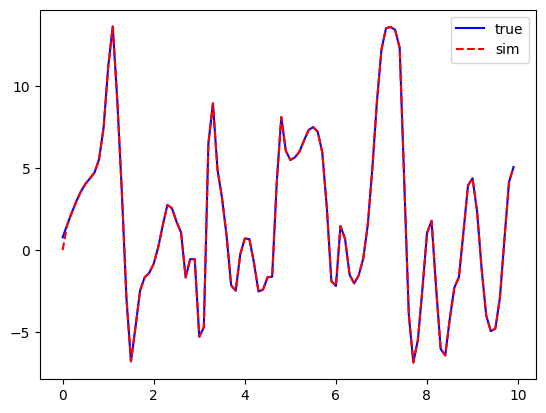

In [ ]:
s = np.s_[:100]

fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Us.T[i, s], label="true", color="blue")
ax.plot(tls[s], Us_sim.T[i, s], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

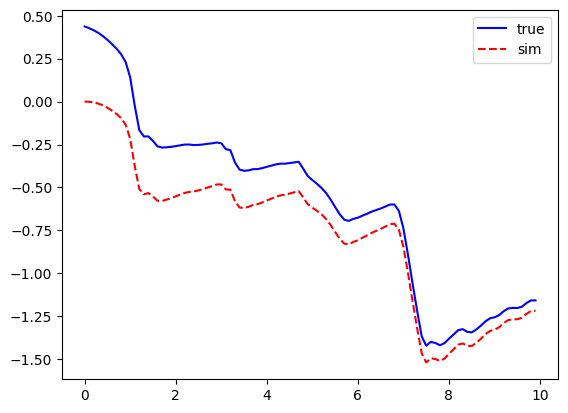

In [ ]:
fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Vs[s, 0, i], label="true", color="blue")
ax.plot(tls[s], Vs_sim[s, 0, i], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

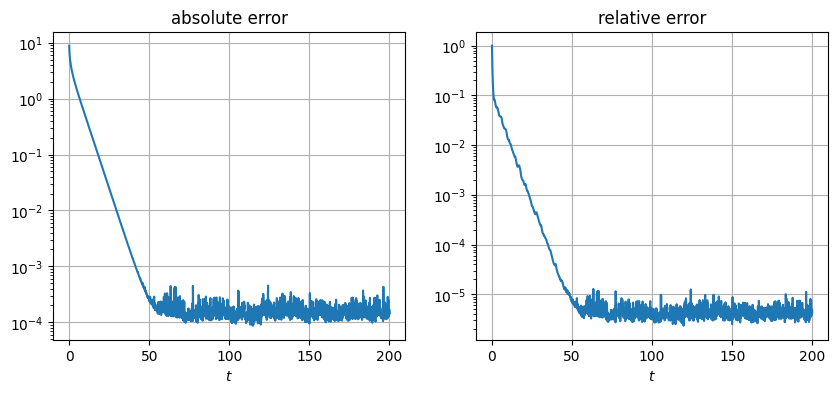

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

states = sol.sol(tls)
states_sim = sim.sol(tls)

error = np.linalg.norm(states - states_sim, axis=0)
rel_error = error / np.linalg.norm(states, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.semilogy(tls, error)
ax.set_xlabel("$t$")
ax.set_title("absolute error")
ax.grid()

ax = axs[1]
ax.semilogy(tls, rel_error)
ax.set_xlabel("$t$")
ax.set_title("relative error")
ax.grid()

plt.show()

# Evolve without parameter updates (only nudging) but multiple `solve_ivp` calls

That is, simulate for whole time using multiple calls to `solve_ivp`

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

Δt = 10
num_iters = 20
learning_rate = None

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

options = {
    "method": "RK45",
    "rtol": 1e-3,
}
rp.iterate(
    Δt,
    num_iters,
    learning_rate,
    U0,
    V0,
    U0_sim,
    V0_sim,
    options,
    param_update_method=rp._dummy_grad_desc,
)
sol, sim = rp.sol, rp.sim

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

states = sol(tls)
Us, Vs = zip(*(L96.apart(state, I, J) for state in states.T))
Us, Vs = np.stack(Us), np.stack(Vs)

states_sim = sim(tls)
Us_sim, Vs_sim = zip(*(L96.apart(state, I, J_sim) for state in states_sim.T))
Us_sim, Vs_sim = np.stack(Us_sim), np.stack(Vs_sim)

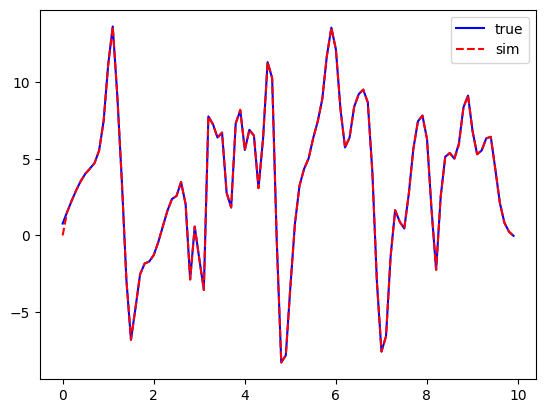

In [ ]:
s = np.s_[:100]

fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Us.T[i, s], label="true", color="blue")
ax.plot(tls[s], Us_sim.T[i, s], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

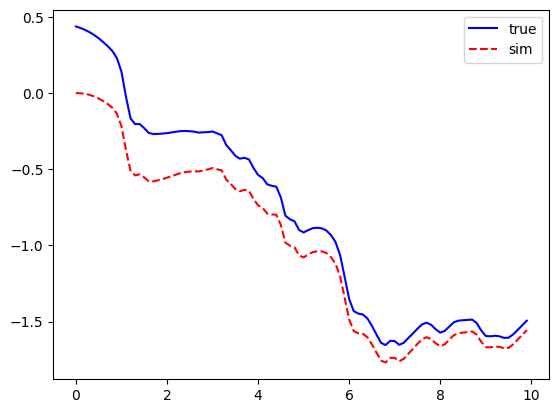

In [ ]:
fig, ax = plt.subplots(1, 1)

i = 0
s = np.s_[:100]
ax.plot(tls[s], Vs[s, 0, i], label="true", color="blue")
ax.plot(tls[s], Vs_sim[s, 0, i], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

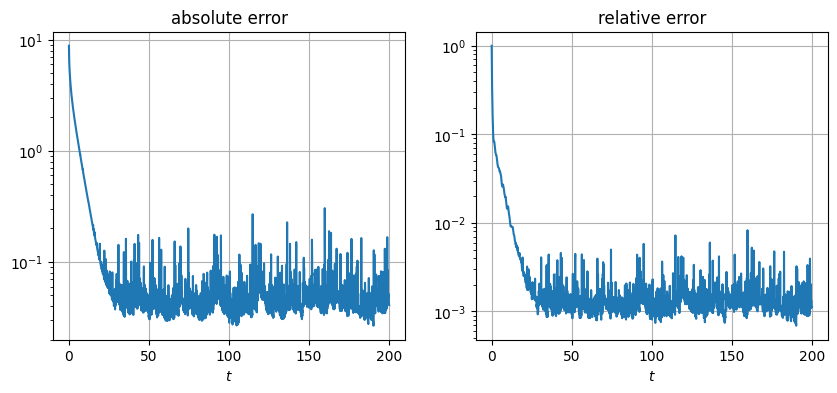

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

error = np.linalg.norm(states - states_sim, axis=0)
rel_error = error / np.linalg.norm(states, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.semilogy(tls, error)
ax.set_xlabel("$t$")
ax.set_title("absolute error")
ax.grid()

ax = axs[1]
ax.semilogy(tls, rel_error)
ax.set_xlabel("$t$")
ax.set_title("relative error")
ax.grid()

plt.show()